# ADA Project : Milestone 2

## Cracking the Hollywood interview

On average, the production of a major box office movie costs $65 million, without counting the marketing and distribution fees. Unlike house construction, which usually ends up exactly like the pre-sketched plan, making a movie is unpredictable and anticipating the audience’s opinion is nearly impossible despite the effort and money spent.
Thus, producing it the right way is a crucial job that requires long-time studies and decision-making about the relevant parts that define the movie. This includes the storyline, the script, the actors, the budget, and many more.
This motivates our goal of studying the successful as well as failed films in terms of public ratings collected through the IMDB databases as well as the box office revenue. We mainly analyze the different metrics that define a movie in order to come up with a set of criteria that, if present, will more likely make it successful.

### 1) Imports

In [65]:
import math
import json
import nltk
import gzip
import pickle
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import scipy.stats as stats
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from collections import Counter
from __future__ import annotations

from nltk.sentiment import SentimentIntensityAnalyzer
import patsy.builtins as pat

import xml.etree.ElementTree as ET
import statsmodels.formula.api as smf

import statsmodels.formula.api as smf
import statsmodels.api as sm

from IPython.display import display, Markdown, Latex



### 2) Utility functions

Some basic functions that may be helpful later.

In [66]:
def freebase_to_wiki_id(freebase_id: str) -> str | None:
    """
    Query Wikidata ID from Freebase ID
    :param freebase_id: str
    :return: corresponding wiki ID
    """
    url = f"https://www.wikidata.org/w/index.php?search={freebase_id}&title=Special%3ASearch&go=Go"
    res = BeautifulSoup(requests.get(url).text, "html.parser")\
        .find("div", {"class": "mw-search-result-heading"})
    if res is not None:
        return res.find("a")["href"].split("/")[-1]
    return None

path_corenlp = '../data/corenlp_plot_summaries/'

def parse_summaries(file: str) -> BeautifulSoup:
    """
    Parse XML npl processed summary
    :param file: name of
    :return: BeautifulSoup object
    """
    with gzip.open(path_corenlp + file, 'rb') as f:
        data = f.read()
    return BeautifulSoup(data, features="xml")

### 3) Movie metadata analysis and processing

We start by analyzing and cleaning the movies' metadata file ``movie.metadata.tsv``.

#### 3.1) Getting more revenue data

In [67]:
# Load the dataset
metadata_df = pd.read_csv('data/movie.metadata.tsv', sep="\t")
metadata_df

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples)
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [68]:
# Get some insights
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Wikipedia movie ID                         81741 non-null  int64  
 1   Freebase movie ID                          81741 non-null  object 
 2   Movie name                                 81741 non-null  object 
 3   Movie release date                         74839 non-null  object 
 4   Movie box office revenue                   8401 non-null   float64
 5   Movie runtime                              61291 non-null  float64
 6   Movie languages                            81741 non-null  object 
 7   Movie countries (Freebase ID:name tuples)  81741 non-null  object 
 8   Movie genres (Freebase ID:name tuples)     81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


Since the revenue is an important feature in our study, let's see if we have enough data:

In [69]:
metadata_df['Movie box office revenue'].isna().sum() / metadata_df.shape[0] * 100

89.72241592346558

Around 90% of the movie revenues are absent. We used the ``boxoffice.csv`` dataset to enrich our dataset:

In [70]:
def extract_release_year(df):
    """
    Exctracts the release year from the release date as a new column
    :param df: the dataframe
    :return: The extended dataframe
    """
    df['Movie release year'] = df['Movie release date'].astype(str).str[:4]
    df = df[df["Movie release year"].str.contains("nan") == False].copy()
    df['Movie release year'] = df['Movie release year'].apply(lambda x: int(x))
    return df

In [71]:
# Add a release year column for convenience
metadata_df = extract_release_year(metadata_df)

In [72]:
# Load the revenue dataset
revenue = pd.read_csv('data/boxoffice.csv', sep=',')

In [73]:
# Fill some of the absent revenue fields from the boxoffice dataset
metadata_df.set_index(['Movie name','Movie release year'])
revenue.set_index(['title','year'])
metadata_df['Movie box office revenue'].fillna(revenue['lifetime_gross'], inplace=True)

In [74]:
metadata_df['Movie box office revenue'].isna().sum() / metadata_df.shape[0] * 100

71.77808361950319

We gained around 20% of relevant data!

#### 3.2) Additional data on movies' ratings

We add information about movie's ratings thanks to the IMDb dataset.
The IMDb dataset is described at <https://www.imdb.com/interfaces/> , which is a version granted by IMDb for academic purposes. We have asked and being authorised by the IMDb team to have access to it.

The following gets IMDb movies' ratings from ``imdb_title_ratings.tsv``.

**IMDb ratings dataset:**

- **tconst**: unique identifier of the movie
- **averageRating**: average of user ratings
- **numVotes**: number of ratings submitted for the movie

In [75]:
# IMDb ratings dataset
imdb_ratings_df = pd.read_csv('data/imdb_title_ratings.tsv', sep='	')
imdb_ratings_df.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1924
1,tt0000002,5.8,260
2,tt0000003,6.5,1733
3,tt0000004,5.6,174
4,tt0000005,6.2,2545


**IMDb videos' metadata dataset:**

- **tconst**: unique identifier of title
- **titleType**: type of the title (movie, TV series, etc.)
- **primaryTitle**: title the film is known for
    - **originalTitle**: original title (in original language) of film
- **isAdult**: indicator about adult category
- **startYear**: release year
- **endYear**: end year (for series)
- **runtimeMinutes**: duration of the title in minutes
- **genres**: up to three genres associated to the title

In [76]:
# IMDb videos' metadata dataset
imdb_names_df = pd.read_csv('data/imdb_title_basics.tsv', sep='	', low_memory=False)
# Only keep audiovisual products labeled as movies
imdb_names_df = imdb_names_df[imdb_names_df['titleType'] == 'movie']
imdb_names_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


In [77]:
# Join between IMDb movies' rating and metadata
imdb_ratings_meta = imdb_ratings_df.merge(imdb_names_df, on='tconst', how='inner')
imdb_ratings_meta.head()

,tconst,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000009,5.2,200,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
1,tt0000502,4.2,14,movie,Bohemios,Bohemios,0,1905,\N,100,\N
2,tt0000574,6.0,794,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
3,tt0000591,5.1,20,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
4,tt0000615,4.3,23,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama


We merge the original CMU dataset with the IMDb dataset.

In [78]:
# Join between CMU and IMDb datasets
ratings_merge = metadata_df.merge(imdb_ratings_meta, left_on='Movie name', right_on = 'primaryTitle', how='inner')
ratings_merge.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release year,...,averageRating,numVotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,4.9,55229,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi"
1,28463795,/m/0crgdbh,Brun bitter,1988,700059566.0,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,...,5.7,40,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama"
2,261236,/m/01mrr1,A Woman in Flames,1983,659363944.0,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,...,6.0,589,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama
3,13696889,/m/03cfc81,The Gangsters,1913-05-29,652270625.0,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,...,5.7,31,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime"
4,23070193,/m/064mmt5,The Gangsters,1956,NaN,NaN,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/05p553"": ""Comedy film""}",1956,...,5.7,31,movie,The Gangsters,Les truands,0,1957,\N,105,"Comedy,Crime"


We clean the joined datasets by keeping entries that are consistent in their release dates. In other words, release year has to be similar in both datasets, otherwise we consider an entry may contain erroneous or noisy data and we discard it.

In [79]:
# Format movie release date
ratings_merge = extract_release_year(ratings_merge)

In [80]:
# Filter pairs (obtained by join) by almost same release year (max. difference of two)
ratings_merge = ratings_merge[ratings_merge['startYear'] != '\\N']
ratings_merge['releaseDiff'] = (ratings_merge['Movie release year'].astype(int) - ratings_merge['startYear'].astype(int)).abs()
ratings_merge = ratings_merge[ratings_merge['releaseDiff'] <= 2]

We also clean the joined datasets with respect to the movie's runtime.

In [81]:
# Filter pairs (obtained by join) by almost same runtime (max. difference of 10% with respect of the CMU duration)
# First, we handle the problem of non-existing runtime information for some entries
ratings_merge = ratings_merge[ratings_merge['runtimeMinutes'] != '\\N']
ratings_merge['Movie runtime'].fillna(-1, inplace=True)

ratings_merge['runtimeDiff'] = (ratings_merge['Movie runtime'].astype(int) - ratings_merge['runtimeMinutes'].astype(int)).abs()
ratings_merge = ratings_merge[ratings_merge['runtimeDiff'] <= ratings_merge['Movie runtime']/10]

In [82]:
ratings_merge.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release year,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,releaseDiff,runtimeDiff
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,...,movie,Ghosts of Mars,Ghosts of Mars,0,2001,\N,98,"Action,Horror,Sci-Fi",0,0
1,28463795,/m/0crgdbh,Brun bitter,1988,700059566.0,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988,...,movie,Brun bitter,Brun bitter,0,1988,\N,83,"Crime,Drama",0,0
2,261236,/m/01mrr1,A Woman in Flames,1983,659363944.0,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983,...,movie,A Woman in Flames,Die flambierte Frau,0,1983,\N,106,Drama,0,0
6,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,623357910.0,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",2002,...,movie,The Sorcerer's Apprentice,The Sorcerer's Apprentice,0,2001,\N,86,"Adventure,Family,Fantasy",1,0
13,12621957,/m/05pdd86,The Sorcerer's Apprentice,2010-07-08,215283742.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",2010,...,movie,The Sorcerer's Apprentice,The Sorcerer's Apprentice,0,2010,\N,109,"Action,Adventure,Family",0,2


We clean the 'ratings_merge' dataframe (which is the result of joining IMDb's ratings and CMU datasets).
We remove duplicated or non-relevant columns and we order columns in more logical order (with adjacent columns containing similar information)

In [83]:
# Remove unnecessary columns
ratings_merge = ratings_merge.drop('releaseDiff', axis=1)
ratings_merge = ratings_merge.drop('runtimeDiff', axis=1)
ratings_merge = ratings_merge.drop('endYear', axis=1)
ratings_merge = ratings_merge.drop('Movie name', axis=1)
ratings_merge = ratings_merge.drop('Movie release date', axis=1)
ratings_merge = ratings_merge.drop('runtimeMinutes', axis=1)
ratings_merge = ratings_merge.drop('titleType', axis=1)

# Reorder columns
ratings_merge = ratings_merge[['Wikipedia movie ID', 'Freebase movie ID', 'tconst', 'primaryTitle', 'originalTitle', 'Movie box office revenue', 'averageRating', 'numVotes', 'Movie runtime', 'Movie languages', 'Movie countries (Freebase ID:name tuples)', 'Movie genres (Freebase ID:name tuples)', 'genres', 'isAdult', 'startYear']]

In [84]:
ratings_merge.head()

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),genres,isAdult,startYear
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",0,2001
1,28463795,/m/0crgdbh,tt0094806,Brun bitter,Brun bitter,700059566.0,5.7,40,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama",0,1988
2,261236,/m/01mrr1,tt0083949,A Woman in Flames,Die flambierte Frau,659363944.0,6.0,589,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Drama,0,1983
6,18998739,/m/04jcqvw,tt0120166,The Sorcerer's Apprentice,The Sorcerer's Apprentice,623357910.0,4.2,605,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Adventure,Family,Fantasy",0,2001
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","Action,Adventure,Family",0,2010


Now that 'ratings_merge' represent the an extended 'metadata_df' dataframe (with rating information and more consistent entries), we refer this 'ratings_merge' as the new 'metadata_df'.

In [85]:
# Assignment for extended dataframe
metadata_df = ratings_merge

# Useful labels for revenue and ratings
box_office_rev = 'Movie box office revenue'
box_office_rat = 'averageRating'

Now, we have a dataframe complete with non null revenues and ratings for sufficiently many movies, ready for use:

In [86]:
metadata_df = metadata_df[metadata_df[box_office_rev].notnull() & metadata_df[box_office_rat].notnull()].copy()
metadata_df

,Wikipedia movie ID,Freebase movie ID,tconst,primaryTitle,originalTitle,Movie box office revenue,averageRating,numVotes,Movie runtime,Movie languages,Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),genres,isAdult,startYear
0,975900,/m/03vyhn,tt0228333,Ghosts of Mars,Ghosts of Mars,14010832.0,4.9,55229,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Action,Horror,Sci-Fi",0,2001
1,28463795,/m/0crgdbh,tt0094806,Brun bitter,Brun bitter,700059566.0,5.7,40,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","Crime,Drama",0,1988
2,261236,/m/01mrr1,tt0083949,A Woman in Flames,Die flambierte Frau,659363944.0,6.0,589,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Drama,0,1983
6,18998739,/m/04jcqvw,tt0120166,The Sorcerer's Apprentice,The Sorcerer's Apprentice,623357910.0,4.2,605,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Adventure,Family,Fantasy",0,2001
13,12621957,/m/05pdd86,tt0963966,The Sorcerer's Apprentice,The Sorcerer's Apprentice,215283742.0,6.1,162916,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...","Action,Adventure,Family",0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86925,1191380,/m/04f_y7,tt0120514,Wilde,Wilde,2158775.0,6.9,17316,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/014tss"": ""Kingdom of Great Britain"", ""/m/...","{""/m/0hn10"": ""LGBT"", ""/m/017fp"": ""Biography"", ...","Biography,Drama,Romance",0,1997
86926,54540,/m/0f7hw,tt0094898,Coming to America,Coming to America,288752301.0,7.1,208493,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...","Comedy,Romance",0,1988
86931,7761830,/m/0kvgqb,tt0100666,Spaced Invaders,Spaced Invaders,15369573.0,5.3,3738,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie...","Adventure,Comedy,Sci-Fi",0,1990
86936,1918494,/m/0660qx,tt0120202,State and Main,State and Main,6944471.0,6.7,21482,106.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0gf28"": ""Parody"", ""/m/09n5t_"": ""Americana...","Comedy,Drama",0,2000


IMDb genres processing:

In [87]:
metadata_df["Movie genres: values"] = metadata_df["genres"].apply(lambda x: x.split(","))
metadata_df.drop("genres", inplace=True)

KeyError: "['genres'] not found in axis"

#### 3.3) Initial revenue and rating distributions

In this section, we examine basic facts and distributions of our data, starting with the global distribution of the revenue.

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Box office revenue', fontsize = 15)
plt.ylabel('Number of movies ', fontsize=15)
plt.title('Box office revenue of all the movies', fontsize=15)
sns.histplot(data=metadata_df[box_office_rev], log_scale=True)
plt.show()

Revenue seems to be slightly heavy tailed. Indeed:

In [ ]:
metadata_df[box_office_rev].describe()

The mean is 3.528042e+07, whilst the median is 5.656388e+06, an order of magnitude smaller.
Let's examine the ratings' distribution:

In [ ]:
plt.figure(figsize=(5, 5))
plt.xlabel('Movie rating', fontsize = 15)
plt.ylabel('Number of movies ', fontsize=15)
plt.title('IMDb rating of all the movies', fontsize=15)
sns.histplot(data=metadata_df[box_office_rat])
plt.show()

This distribution seems closer to normal, with a few peaks.

In [ ]:
metadata_df[box_office_rat].describe()

Median and mean are close. Is the distribution really approximately normal?

In [ ]:
stats.normaltest(metadata_df[box_office_rat])

p-value is basically 0, we can confidently reject the hypothesis that the data comes from a normal distribution.

Let's have a quick look at the influence of the year when a movie was released on both rating and revenue.

In [ ]:
sums_year = metadata_df.groupby('startYear')[[box_office_rev]].sum()[1:]
means_year = metadata_df.sort_values(by="startYear")

In [ ]:
def plot_by_year(df: pd.Series | pd.DataFrame, prefix: str, metric: str, col: str, log_yscale=True):
    """
    Plot a year grouped column
    :param df: said column
    :param prefix: str
    :param metric: what is being plotted
    :param log_yscale: bool
    :param col: where to find data in df
    """
    fig, ax = plt.subplots()

    fig.set_size_inches(16, 8)
    ax.set_xlabel('Release year', fontsize=18)
    ax.set_ylabel(f'{prefix} {metric}', fontsize=16)
    ax.set_title(f'{prefix} {metric} by year', fontsize=16)
    ax.set_label("Floats")
    if prefix == "Mean":
        l = sns.lineplot(data=df, x="startYear", y=col, legend="brief")
    else:
        l = sns.lineplot(data=df, legend="brief")
    if log_yscale:
        l.set_yscale("log")
    plt.xticks(rotation=90)

    plt.show()

In [ ]:
plot_by_year(means_year[80:-10], "Mean", "box office revenue", "Movie box office revenue")

An upwards trend of mean expected revenue is to be expected, especially since more money gets thrown into the film industry:

In [ ]:
plot_by_year(sums_year, "Total", "box office revenue", "Movie box office revenue")

Now let us do the same for rating:

In [ ]:
plot_by_year(means_year[80:-10], "Mean", "rating", "averageRating", log_yscale=False)

Interestingly, between the 1960 and the 1985, IMDb average ratings have dropped, before plateauing. We will have to see if this is tied to the number of ratings submitted. Now, what about the dependence between rating and revenue?

In [ ]:
stats.spearmanr(metadata_df[box_office_rev], metadata_df[box_office_rat])

The p-value being this small rejects that rating and revenue are uncorrelated. However, that correlation seems to be small. Later, it might be interesting to have a look at this correlation *per year* rather than globally.

Lastly, we also plot the runtime just to check whether there is anything interesting to be seen:

In [ ]:
sns.histplot(data=metadata_df["Movie runtime"])

In [ ]:
metadata_df["Movie runtime"].describe()

In [ ]:
plot_by_year(means_year, "Mean", "movie runtime", "Movie runtime", log_yscale=False)

Runtime has increased during the first half of the 20th century. It might be worth studying how runtime affects rating and revenue.

#### 3.4) Effect of genre, country and language on rating and revenue

We move on to the meat and potatoes of metadata analysis: how genre, country and language affect rating and revenue. Some preprocessing first to add indicator variables for each genre, country and language.

In [ ]:
def remove_first_and_last_chars(input_str: str) -> str:
    """
    Remove the first and last char of a string.
    :param input_str
    :return: processed string
    """
    if len(input_str) < 2:
        return ""
    return input_str[1:-1]

def separate_id_from_data(paired_string: str, remove_brackets=True) -> (str, str):
    """
    Separates "{"FreebaseID": "some string"}" strings into ("FreebaseID", "some string") tuples.
    :param paired_string: input paired string
    :param remove_brackets: if True, remove the leading and trailing curly brackets
    :return: said tuple of strings
    """
    if remove_brackets:
        paired_string = remove_first_and_last_chars(paired_string)

    ls = paired_string.split(":")
    for i, s in enumerate(ls):
        ls[i] = remove_first_and_last_chars(s.strip())

    if len(ls) < 2:
        return None, None
    return ls[0], ls[1]

def separate_ids_from_list_data(list_paired_string: str) -> (list, list):
    """
    Separates "{"FreebaseID1": "some string 1", "FreebaseID2": "some string 2", etc.}" strings
    into two lists: (["FreebaseID1", "FreebaseID2", ...], ["some string 1", "some string 2", ...]).
    :param list_paired_string: input list of pairs as string
    :return: said tuple of lists
    """
    list_paired_string = remove_first_and_last_chars(list_paired_string)
    split_pairs = list_paired_string.split(",")
    tupled_pairs = [separate_id_from_data(pair, remove_brackets=False) for pair in split_pairs]
    return [p[0] for p in tupled_pairs], [p[1] for p in tupled_pairs]

def col_to_col_values(column_name: str) -> str:
    """
    String formatting for value column names
    :param column_name: original column name
    :return: said formatted string
    """
    return f"{column_name}: values"

def append_processed_columns(df: pd.DataFrame, column_name: str):
    """
    Separate Freebase IDs from values
    :param df: data, modified in place
    :param column_name: name of column where to separate {Freebase ID: value} pairs
    """
    vals = df[column_name].apply(separate_ids_from_list_data).values.copy()
    df[f"{column_name}: Freebase IDs"] = [vals[i][0] for i in range(len(vals))]
    df[col_to_col_values(column_name)] = [vals[i][1] for i in range(len(vals))]

In [ ]:
metadata_df.rename(columns={"Movie countries (Freebase ID:name tuples)": "Movie countries",
                    "Movie genres (Freebase ID:name tuples)": "Movie genres"}, inplace=True)

cols_to_process = ["Movie countries", "Movie genres", "Movie languages"]
for col in cols_to_process:
    append_processed_columns(metadata_df, col)

metadata_df

In [ ]:
def distinct_values(column_name: str, raw_name: bool=False) -> set:
    """
    Get all values from a column
    :param column_name: said column
    :return: set of values
    """
    col_name = column_name if raw_name else col_to_col_values(column_name)
    return set.union(*metadata_df[col_name].apply(set).values)

def name_appended_column(prefix: str, val: str) -> str:
    """
    Format column name
    :param prefix: str
    :param val: str
    :return: str
    """
    return f"{prefix}: {val}"

def append_indicator_columns(df: pd.DataFrame, all_values: set, column_name: str, prefix: str) -> pd.DataFrame:
    """
    Add columns to the right of a dataframe indicating whether a particular value is present or not
    in some initial column listing values of the same family
    :param df: data (not modified)
    :param all_values: all possible values
    :param column_name: column to inspect
    :param prefix: str
    :return: Dataframe with added columns
    """
    cols = [df[col_to_col_values(column_name)]
            .apply(lambda x: 1 if val in x else 0)
            .rename(name_appended_column(prefix, val))
            for val in all_values]
    cols.insert(0, df)
    return pd.concat(cols, axis=1)

Store all genres and countries encountered:

In [ ]:
all_countries = distinct_values("Movie countries")
all_genres = distinct_values("Movie genres")
all_languages = distinct_values("Movie languages")

genre_prefix = "genre"
langs_prefix = "lang"
cntry_prefix = "country"

Then, let's check the resulting dataframe:

In [ ]:
for ls in [(all_countries, "Movie countries", cntry_prefix),
            (all_genres, "Movie genres", genre_prefix),
            (all_languages, "Movie languages", langs_prefix)]:
    metadata_df = append_indicator_columns(metadata_df, *ls)

metadata_df

For pragmatic purposes such as visualization, we will only treat, in the following, either the $n$ most frequent genres, or genres that are sufficiently frequent.

In [ ]:
from functools import cmp_to_key

def retrieve_n_most_frequent(df: pd.DataFrame, n: int, all_vals: list[str], prefix: str) -> list:
    """
    Retrieve the n most frequent genres, languages or countries, sorted in descending order
    of frequency
    :param df: data
    :param n: integer, max number of values to retrieve
    :param all_vals: all possible values
    :param prefix: str
    :return: said list
    """
    def comparator(val1, val2):
        mean_val1 = df[name_appended_column(prefix, val1)].mean()
        mean_val2 = df[name_appended_column(prefix, val2)].mean()
        return mean_val1 - mean_val2
    return sorted(all_vals, key=cmp_to_key(comparator), reverse=True)[:n]

def retrieve_frequent(df: pd.DataFrame, all_vals: list, prefix: str, freq_threshold=0.05) -> list:
    """
    Filter the values with a sufficiently high frequency
    :param df: data
    :param all_vals: all possible values
    :param prefix: str
    :param freq_threshold: float
    :return: list of sufficiently frequent values
    """
    return list(
        filter(
            lambda val: df[name_appended_column(prefix, val)].mean() > freq_threshold,
            all_vals
        )
    )

def map_to_col_names(data_names: list, prefix: str) -> list:
    """
    Convert data values into column names
    :param data_names: list of  data values
    :param prefix: str
    :return: list of formatted column names
    """
    f = lambda x: name_appended_column(prefix, x)
    return list(map(f, data_names))

In [ ]:
most_freq_genres = retrieve_n_most_frequent(metadata_df, 35, all_genres, genre_prefix)
suff_freq_genres = retrieve_frequent(metadata_df, all_genres, genre_prefix, freq_threshold=0.03)

most_freq_langs = retrieve_n_most_frequent(metadata_df, 35, all_languages, langs_prefix)
suff_freq_langs = retrieve_frequent(metadata_df, all_languages, langs_prefix, freq_threshold=0.03)

most_freq_cntry = retrieve_n_most_frequent(metadata_df, 35, all_countries, cntry_prefix)
suff_freq_cntry = retrieve_frequent(metadata_df, all_countries, cntry_prefix, freq_threshold=0.03)

Our next step will be to examine genres, countries and languages that have are correlated to rating and revenue, and try to understand which ones optimize either metric.

In [ ]:
def find_correlated_metadata(df: pd.DataFrame, freq_data: list, success_metric: str, prefix: str, sig_level=0.05) -> list:
    """
    Among a list of sufficiently frequent data taken from the metadata dataframe,
    find the values such that they are correlated to a movie's success metric with
    a p-value less than sig-level.
    :param df: input dataframe
    :param freq_data: column names to search in
    :param success_metric: str, name of column in df
    :param prefix: str
    :param sig_level: significance level, defaults to 5%
    :return: described list
    """
    correlated_data = []

    for value in freq_data:
        res = stats.spearmanr(df[success_metric], df[name_appended_column(prefix, value)])
        if res.pvalue < sig_level:
            correlated_data.append(value)
    return correlated_data

In [ ]:
correlated_genres_to_revenue = find_correlated_metadata(metadata_df, suff_freq_genres, box_office_rev, genre_prefix)
correlated_langs_to_revenue = find_correlated_metadata(metadata_df, most_freq_langs, box_office_rev, langs_prefix)
correlated_cntry_to_revenue = find_correlated_metadata(metadata_df, most_freq_cntry, box_office_rev, cntry_prefix)

correlated_genres_to_rating = find_correlated_metadata(metadata_df, suff_freq_genres, box_office_rat, genre_prefix)
correlated_langs_to_rating = find_correlated_metadata(metadata_df, most_freq_langs, box_office_rat, langs_prefix)
correlated_cntry_to_rating = find_correlated_metadata(metadata_df, most_freq_cntry, box_office_rat, cntry_prefix)

In [ ]:
def plot_metadata_frequency_against_metric(df: pd.DataFrame, prefix: str,  titled_data: list, success_metric: str, title: str, log_scale=True):
    """
    Generating a grid of histograms
    :param df: data
    :param prefix: str
    :param titled_data: titles of data, to be converted to column names
    :param success_metric: measured column name
    :param title: str, figure title
    :param log_scale: determines the scale of the axes
    """

    # Making the data fit into a square grid...
    squares = np.arange(8) ** 2
    shifted_squares = squares - len(titled_data)
    smallest_big_enough_square = squares[np.argmax(shifted_squares > 0) - 1]

    tested_data = map_to_col_names(titled_data, prefix)[:smallest_big_enough_square]
    size = int(np.sqrt(smallest_big_enough_square))

    fig, ax = plt.subplots(size, size, figsize=(11, 11), sharex = True)
    for i in range(smallest_big_enough_square):
        sbplt = ax[i%size, math.floor(i/size)]
        sns.histplot(ax=sbplt, data=df[df[tested_data[i]] == 1][success_metric], log_scale=log_scale)
        sbplt.set_title(titled_data[i])

    fig.suptitle(title, fontsize=18)
    fig.tight_layout()

In [ ]:
plot_metadata_frequency_against_metric(metadata_df, genre_prefix, correlated_genres_to_revenue, box_office_rev, title="Plotting revenue against genres")

In [ ]:
plot_metadata_frequency_against_metric(metadata_df, genre_prefix, correlated_genres_to_rating, box_office_rat, title="Plotting rating against genres", log_scale=False)

In [ ]:
plot_metadata_frequency_against_metric(metadata_df, cntry_prefix, correlated_cntry_to_revenue, box_office_rev, title="Plotting revenue against countries")

In [ ]:
plot_metadata_frequency_against_metric(metadata_df, cntry_prefix, correlated_cntry_to_rating, box_office_rat, title="Plotting rating against countries", log_scale=False)

In [ ]:
plot_metadata_frequency_against_metric(metadata_df, langs_prefix, correlated_langs_to_revenue, box_office_rev, title="Plotting revenue against languages")

In [ ]:
plot_metadata_frequency_against_metric(metadata_df, langs_prefix, correlated_langs_to_rating, box_office_rat, title="Plotting rating against languages", log_scale=False)

Interesting differences can already be seen. For example, the 3 initial peaks in the rating histogram have become 5 peaks in English drama movies coming from the US. Later, it will be interesting to check the correlation of rating and revenue on a *per year* basis too.

In [ ]:
def formula_rhs_string(prefix, list_all_vars):
    return " + ".join(list(map(lambda x: f'C(pat.Q("{name_appended_column(prefix, x)}"))', list_all_vars)))

def linear_reg(success_metric, prefix_var, list_vars):
    return smf.ols(formula=success_metric + ' ~ ' + formula_rhs_string(prefix_var, list_vars), data=metadata_df).fit()


In [ ]:
reg_rating_genres = linear_reg(box_office_rat, genre_prefix, correlated_genres_to_rating)
print(reg_rating_genres.summary())


In [ ]:
q_box_office_rev = f"pat.Q('{box_office_rev}')"
reg_revenue_genres = linear_reg(q_box_office_rev, genre_prefix, correlated_genres_to_revenue)
print(reg_revenue_genres.summary())

### 4) Actors Metadata analysis

Here we focus on analysing the characters metadata in ``charcater.metadata.tsv``

In [89]:
# Load the dataset
names_char = ['Wikipedia movie ID',
              'Freebase movie ID',
              'Movie release date',
              'Character name',
              'Actor date of birth',
              'Actor gender',
              'Actor height',
              'Actor ethnicity',
              'Actor name',
              'Actor age at movie release',
              'Freebase character/actor map ID',
              'Freebase character ID',
              'Freebase actor ID']

characters_metadata_df = pd.read_csv('data/character.metadata.tsv', sep='\t', names = names_char)

In [90]:
characters_metadata_df.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [91]:
characters_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Wikipedia movie ID               450669 non-null  int64  
 1   Freebase movie ID                450669 non-null  object 
 2   Movie release date               440674 non-null  object 
 3   Character name                   192794 non-null  object 
 4   Actor date of birth              344524 non-null  object 
 5   Actor gender                     405060 non-null  object 
 6   Actor height                     154824 non-null  float64
 7   Actor ethnicity                  106058 non-null  object 
 8   Actor name                       449441 non-null  object 
 9   Actor age at movie release       292556 non-null  float64
 10  Freebase character/actor map ID  450669 non-null  object 
 11  Freebase character ID            192804 non-null  object 
 12  Fr

In [92]:
characters_metadata_df['Actor gender'].describe()

count     405060
unique         2
top            M
freq      270257
Name: Actor gender, dtype: object

##### Age at movie release:

In [93]:
characters_metadata_df['Actor age at movie release'].describe()

count    292556.000000
mean         37.788523
std          20.587870
min       -7896.000000
25%          28.000000
50%          36.000000
75%          47.000000
max         103.000000
Name: Actor age at movie release, dtype: float64

We noticed that the attribute 'Age at movie release' contains negative values

In [94]:
characters_metadata_df[characters_metadata_df['Actor age at movie release'] < 0]

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
767,15007384,/m/03h4h5p,1934-05-02,NaN,1963-11-07,NaN,NaN,NaN,Franck Dubosc,-29.0,/m/0bwb9k3,NaN,/m/01wlly9
2286,2553539,/m/07mlsy,1918-04-14,NaN,1931-03-25,M,NaN,NaN,Tom Wilson,-12.0,/m/0jsqm1,NaN,/m/0382zh
3892,5917218,/m/0fdf3y,1965,NaN,1983-03-03,F,1.75,NaN,Kim Smith,-18.0,/m/04mb5kf,NaN,/m/03pjkv
6666,73930,/m/0jsjm,1924,Robert,1972-11-07,M,1.80,NaN,Jason London,-48.0,/m/01xrptw,/m/02nwfsk,/m/04kdmg
7188,21242801,/m/05bzjwj,1955-08-07,NaN,1973-08-01,M,1.79,/m/03ttfc,Eduardo Noriega,-17.0,/m/0cg2f0f,NaN,/m/0bkkw0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
446570,3642891,/m/09rsyj,1999-10-03,Tess,2936-12-24,F,NaN,NaN,J.J. McColl,-937.0,/m/0l2rdfz,/m/0l2rdg1,/m/0l2rdg8
446581,25868401,/m/09v6ykm,1955,NaN,1967-05-31,F,1.67,/m/03ts0c,Sandrine Bonnaire,-12.0,/m/04j05tr,NaN,/m/07wn_5
446583,8595532,/m/02799cv,1944-02-23,NaN,1947-05-28,M,NaN,NaN,Kevin O'Shea,-3.0,/m/02vcqnq,NaN,/m/02q384f
446816,1276915,/m/04pg6m,1941-06-20,NaN,1957-04-19,M,NaN,NaN,Tony Martin,-15.0,/m/0cg164j,NaN,/m/07q_fg


In [95]:
characters_metadata_df['Actor age at movie release'] = characters_metadata_df['Actor age at movie release'].apply(abs)

(0.0, 100.0)

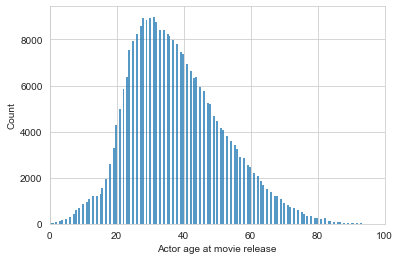

In [96]:
sns.histplot(data=characters_metadata_df, x="Actor age at movie release")
plt.xlim(0, 100)

#### Effect of gender on movie revenue

In [97]:
characters_metadata_df

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [98]:
characters_metadata_df2 = characters_metadata_df.join(pd.get_dummies(characters_metadata_df['Actor gender']).rename(columns=lambda x : f'{x}_onehot'))

In [99]:
characters_metadata_df2

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,F_onehot,M_onehot
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,1,0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,1,0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,0,1
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,0,1
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,1,0
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,0,1
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,0,1
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,0,0


In [100]:
revenue_df = metadata_df[['Wikipedia movie ID', 'Movie box office revenue']]

In [101]:
rating_df = metadata_df[['Wikipedia movie ID', 'averageRating']]

In [102]:
characters_metadata_revenue = characters_metadata_df2.merge(revenue_df, left_on='Wikipedia movie ID', right_on = 'Wikipedia movie ID', how='inner')

In [103]:
characters_metadata_rating = characters_metadata_df2.merge(rating_df, left_on='Wikipedia movie ID', right_on = 'Wikipedia movie ID', how='inner')

In [104]:
characters_metadata_revenue

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,F_onehot,M_onehot,Movie box office revenue
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,1,0,14010832.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,1,0,14010832.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,0,1,14010832.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,0,1,14010832.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,1,0,14010832.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123306,6456053,/m/0g605h,1964-12-31,Lady Angela St. Simeon,1923-08-06,F,NaN,NaN,Moira Lister,41.0,/m/0cg4r4r,/m/0hnw0m8,/m/07pfcc,1,0,5400000.0
123307,6456053,/m/0g605h,1964-12-31,Assistant Car Salesman,1933-07-26,M,NaN,NaN,Lance Percival,31.0,/m/0cg01yt,/m/0hnw0ly,/m/052k8b,0,1,5400000.0
123308,6456053,/m/0g605h,1964-12-31,Norwood,1900-08-31,M,NaN,NaN,Roland Culver,64.0,/m/0cs4ftp,/m/0hnw0kl,/m/0412scr,0,1,5400000.0
123309,6456053,/m/0g605h,1964-12-31,Harnsworth,1911-10-03,M,NaN,NaN,Michael Hordern,53.0,/m/0csk5b4,/m/0hnw0mv,/m/015vql,0,1,5400000.0


In [105]:
mod = smf.ols(formula='Q("Movie box office revenue") ~ C(F_onehot) + C(M_onehot)', data=characters_metadata_revenue)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()
# Print thes summary output provided by the library.
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Q("Movie box office revenue")   R-squared:                       0.003
Model:                                       OLS   Adj. R-squared:                  0.003
Method:                            Least Squares   F-statistic:                     177.1
Date:                           Thu, 22 Dec 2022   Prob (F-statistic):           1.53e-77
Time:                                   14:39:46   Log-Likelihood:            -2.4720e+06
No. Observations:                         123311   AIC:                         4.944e+06
Df Residuals:                             123308   BIC:                         4.944e+06
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------

In [106]:
mod = smf.ols(formula='averageRating ~ C(F_onehot) + C(M_onehot)', data=characters_metadata_rating)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     21.17
Date:                Thu, 22 Dec 2022   Prob (F-statistic):           6.44e-10
Time:                        14:39:51   Log-Likelihood:            -1.7704e+05
No. Observations:              123311   AIC:                         3.541e+05
Df Residuals:                  123308   BIC:                         3.541e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.3112      0.010  

#### Effect of actor age on revenue

In [112]:
characters_metadata_revenue

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID,F_onehot,M_onehot,Movie box office revenue
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,1,0,14010832.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,1,0,14010832.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,0,1,14010832.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,0,1,14010832.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,1,0,14010832.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123306,6456053,/m/0g605h,1964-12-31,Lady Angela St. Simeon,1923-08-06,F,NaN,NaN,Moira Lister,41.0,/m/0cg4r4r,/m/0hnw0m8,/m/07pfcc,1,0,5400000.0
123307,6456053,/m/0g605h,1964-12-31,Assistant Car Salesman,1933-07-26,M,NaN,NaN,Lance Percival,31.0,/m/0cg01yt,/m/0hnw0ly,/m/052k8b,0,1,5400000.0
123308,6456053,/m/0g605h,1964-12-31,Norwood,1900-08-31,M,NaN,NaN,Roland Culver,64.0,/m/0cs4ftp,/m/0hnw0kl,/m/0412scr,0,1,5400000.0
123309,6456053,/m/0g605h,1964-12-31,Harnsworth,1911-10-03,M,NaN,NaN,Michael Hordern,53.0,/m/0csk5b4,/m/0hnw0mv,/m/015vql,0,1,5400000.0


In [113]:
age_revenue_groups = characters_metadata_revenue.groupby(['Actor age at movie release']).mean()

In [114]:
age_rating_groups = characters_metadata_rating.groupby(['Actor age at movie release']).mean()

In [115]:
age_revenue_groups

,Wikipedia movie ID,Actor height,F_onehot,M_onehot,Movie box office revenue
Actor age at movie release,,,,,
0.0,8.329955e+06,1.614500,0.600000,0.400000,3.322351e+07
1.0,6.909900e+06,1.775000,0.250000,0.750000,3.446956e+07
2.0,1.475007e+07,1.782500,0.600000,0.400000,6.488345e+07
3.0,1.869772e+06,1.660583,0.307692,0.692308,8.417685e+07
4.0,7.254650e+06,1.729585,0.517241,0.482759,6.273985e+07
...,...,...,...,...,...
94.0,1.145512e+07,1.790000,0.000000,1.000000,6.373775e+07
95.0,7.029570e+05,1.750000,0.000000,1.000000,1.508014e+08
96.0,2.635769e+07,1.630000,0.500000,0.500000,3.979055e+05


In [116]:
age_rating_groups

,Wikipedia movie ID,Actor height,F_onehot,M_onehot,averageRating
Actor age at movie release,,,,,
0.0,8.329955e+06,1.614500,0.600000,0.400000,6.970000
1.0,6.909900e+06,1.775000,0.250000,0.750000,6.175000
2.0,1.475007e+07,1.782500,0.600000,0.400000,6.566667
3.0,1.869772e+06,1.660583,0.307692,0.692308,6.746154
4.0,7.254650e+06,1.729585,0.517241,0.482759,6.206897
...,...,...,...,...,...
94.0,1.145512e+07,1.790000,0.000000,1.000000,6.750000
95.0,7.029570e+05,1.750000,0.000000,1.000000,6.750000
96.0,2.635769e+07,1.630000,0.500000,0.500000,7.450000


In [117]:
merged = age_rating_groups.merge(age_revenue_groups, on = 'Actor age at movie release')[['averageRating', 'Movie box office revenue']]

In [118]:
merged = merged.reset_index()

In [ ]:
# For the plot
#merged.to_csv('age_rating_revenue.csv', index=False)

##### Titles known for:
Since our study focuses on analysing features that contribute to a movie's success, it would be relevant to study actors performance. This can be done by having information on when each actor performed the best.
For this task, we used the  ``imdb_name_basics.tsv`` dataset, which contains the 4 topmost titles an actor is known for.

**IMDb actors dataset:**

- **nconst**: unique identifier of person
- **primaryName**: name the person is known for
- **birthYear**: birth year
- **deathYear**: death year
- **primaryProfession**: top 3 professions of the person
- **knownForTitles**: movies the person is known for


In [ ]:
# Load the IMDb actors dataset
imdb_actors_df = pd.read_csv('data/imdb_name_basics.tsv', sep='	')

In [ ]:
imdb_actors_df.head()

In [ ]:
imdb_actors_df.info()

Since we only have the id of the known for titles, we fetch the title names from the `imdb_names_df`

First we separate each of the titles ids an actor is known for in a single column, then we fetch the name corresponding to each id.

In [ ]:
def get_title_by_index(index):
    """
    Returns the title id at a given index
    :param index: The id index in the list of ids
    :return: The id
    """
    def f(array):
        list_ids = array.split(",")
        corresponding_id = ""
        if index < len(list_ids):
            corresponding_id = list_ids[index]
        return corresponding_id

    return f

imdb_actors_df['knownForTitles1'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(0))
imdb_actors_df['knownForTitles2'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(1))
imdb_actors_df['knownForTitles3'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(2))
imdb_actors_df['knownForTitles4'] = imdb_actors_df['knownForTitles'].apply(get_title_by_index(3))

In [ ]:
imdb_actors_df.head()

In [ ]:
# IMDb movies' metadata dataset
imdb_names_df.head()

In [ ]:
# Keep only relevant columns
imdb_names_reduced_df = imdb_names_df[["tconst", "primaryTitle"]]

In [ ]:
def assign_known_title(index, actors_df, names_df):
    """
    Fetch the known titles names
    :param index: Index of the title in the list
    :param actors_df: actors dataframe
    :param names_df: movie names dataframe
    :return:
    """
    actors_df = actors_df.merge(names_df, left_on="knownForTitles{}".format(index), right_on = 'tconst', how='inner')
    actors_df["knownForTitles{}".format(index)] = actors_df['primaryTitle']
    actors_df = actors_df.drop('tconst', axis=1)
    actors_df = actors_df.drop('primaryTitle', axis=1)
    return actors_df

In [ ]:
imdb_actors_df = assign_known_title(1, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(2, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(3, imdb_actors_df, imdb_names_reduced_df)
imdb_actors_df = assign_known_title(4, imdb_actors_df, imdb_names_reduced_df)

In [ ]:
imdb_actors_df.head()

In [ ]:
imdb_actors_df['knownForTitlesNames'] = imdb_actors_df[imdb_actors_df.columns[6:]].apply(
    lambda x: ','.join(x),
    axis=1
)

In [ ]:
imdb_actors_df = imdb_actors_df.drop('knownForTitles1', axis = 1).drop('knownForTitles2', axis = 1).drop('knownForTitles3', axis = 1).drop('knownForTitles4', axis = 1)

In [ ]:
imdb_actors_df.head()

As an example, let's see what are the titles Leonardo Dicaprio is known for

In [ ]:
result = imdb_actors_df[imdb_actors_df['primaryName'] == "Leonardo DiCaprio"]['knownForTitlesNames']
print(result)

No surprise !

We add the IMDb's casting dataset. It contains the people that have participated in castings for movies and their role in them.
We are not directly using this dataframe in Milestone 2 as it will be joined and applied to data obtained by methods in Milestone 3 (refer to Method 2 at Readme for further information).

**IMDb castings dataset:**

- **tconst**: unique identifier of title
- **ordering**: index identify a row within a specific title
- **nconst**: unique identifier of person
- **category**: category of job in casting
- **job**: job title
- **characters**: name of character if it was an interpretation role

In [ ]:
# IMDb castings dataset
imdb_casting_df = pd.read_csv('data/imdb_title_principals.tsv', sep='	', low_memory=False)
imdb_casting_df.head()

In [ ]:
m = imdb_casting_df[imdb_casting_df['category'] == 'actor']

In [ ]:
m['characters']

### 5) tvtropes clusters analysis

Here we use the clusters in ``tvtropes.clusters.txt`` to see what type of characters an actor tends to play.

In [119]:
# Load the data into a dataframe
with open('data/tvtropes.clusters.txt') as f:
    d = []
    for row in f.readlines():
        t, json_data = row.split('\t')
        data = json.loads(json_data)
        data['type'] = t
        d.append(data)

tv_tropes_df = pd.DataFrame(d)
#tv_tropes_df.set_index("id", inplace=True)

In [120]:
tv_tropes_df.head()

,char,movie,id,actor,type
0,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,absent_minded_professor
1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,absent_minded_professor
2,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,absent_minded_professor
3,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,absent_minded_professor
4,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,absent_minded_professor


In [121]:
# split the type in tokens
tv_tropes_df['type'] = tv_tropes_df['type'].apply(lambda x: ' '.join(x.split('_')))

In [122]:
tv_tropes_df['type'].head()

0    absent minded professor
1    absent minded professor
2    absent minded professor
3    absent minded professor
4    absent minded professor
Name: type, dtype: object

In order to have better insight on the data and also for further analysis on what type of characters are played by each actor, we decide to conduct sentiment analysis on those type. For this task we use the nltk library.

In [123]:
# Load the model
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/hind/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [124]:
# Initialization and example
sia = SentimentIntensityAnalyzer()
sia.polarity_scores('adventurer archeologist')

{'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'compound': 0.296}

In [125]:
def get_sentiment(sentence):
    """
    Compute the sentiment value of a sentence
    :param sentence: The sentence
    :return: -1 for negative, 0 for neutral and 1 for positive
    """
    score = sia.polarity_scores(sentence)
    # If the score is more positive with a less significant neutral value and vice versa
    if score['pos'] > score['neg'] and score['neu'] < 0.5: return 1
    elif score['pos'] < score['neg'] and score['neu'] < 0.5: return -1
    else: return 0

In [126]:
# Create a column sentiment containing the sentiment value of the character type
tv_tropes_df['sentiment'] = tv_tropes_df['type'].apply(get_sentiment).to_frame()

In [127]:
tv_tropes_df.head(10)

,char,movie,id,actor,type,sentiment
0,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,absent minded professor,0
1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,absent minded professor,0
2,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,absent minded professor,0
3,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,absent minded professor,0
4,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,absent minded professor,0
5,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford,adventurer archaeologist,1
6,Indiana Jones,Indiana Jones and the Raiders of the Lost Ark,/m/0k294p,Harrison Ford,adventurer archaeologist,1
7,Indiana Jones,Indiana Jones and the Temple of Doom,/m/0jzx9b,Harrison Ford,adventurer archaeologist,1
8,Evelyn Carnahan-O'Connell,The Mummy,/m/0k5yzc,Rachel Weisz,adventurer archaeologist,1
9,Han,Enter the Dragon,/m/02vd8hn,Shih Kien,arrogant kungfu guy,-1


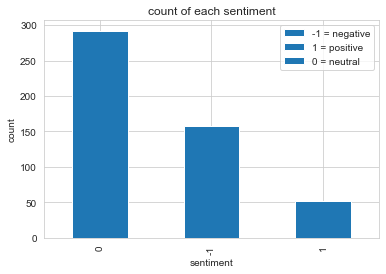

In [128]:
import matplotlib.patches as mpatches

tv_tropes_df['sentiment'].value_counts().plot(kind='bar', xlabel= 'sentiment', ylabel = 'count', title = 'count of each sentiment')
neg_patch = mpatches.Patch(label='-1 = negative')
pos_patch = mpatches.Patch(label='1 = positive')
neu_patch = mpatches.Patch(label='0 = neutral')
blue_patch = mpatches.Patch(color='blue', label='Positive')

plt.legend(handles=[neg_patch, pos_patch, neu_patch])

In [129]:
tv_tropes_df

,char,movie,id,actor,type,sentiment
0,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,absent minded professor,0
1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,absent minded professor,0
2,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,absent minded professor,0
3,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,absent minded professor,0
4,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,absent minded professor,0
...,...,...,...,...,...,...
496,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton,young gun,-1
497,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson,young gun,-1
498,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West,young gun,-1
499,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez,young gun,-1


In [130]:
name_revenue_df = metadata_df[['primaryTitle', 'Movie box office revenue']]

In [131]:
name_rating_df = metadata_df[['primaryTitle', 'averageRating']]

In [141]:
type_df = tv_tropes_df.merge(name_revenue_df, left_on='movie', right_on = 'primaryTitle', how='inner').merge(name_rating_df, left_on='primaryTitle', right_on = 'primaryTitle', how='inner')

In [142]:
type_df

,char,movie,id,actor,type,sentiment,primaryTitle,Movie box office revenue,averageRating
0,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,absent minded professor,0,Flubber,177977226.0,5.3
1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,absent minded professor,0,Richie Rich,38087756.0,5.4
2,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,absent minded professor,0,Them!,2200000.0,7.2
3,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,absent minded professor,0,Stargate,196567262.0,7.0
4,Indiana Jones,Indiana Jones and the Kingdom of the Crystal S...,/m/0jzx78,Harrison Ford,adventurer archaeologist,1,Indiana Jones and the Kingdom of the Crystal S...,786636033.0,6.2
...,...,...,...,...,...,...,...,...,...
520,Katsumoto,The Last Samurai,/m/0k5n1r,Ken Watanabe,warrior poet,0,The Last Samurai,456758981.0,7.8
521,Zohan,You Don't Mess with the Zohan,/m/03hqx35,Adam Sandler,warrior poet,0,You Don't Mess with the Zohan,201802891.0,5.6
522,Tool,The Expendables,/m/05tb1tv,Mickey Rourke,warrior poet,0,The Expendables,274470394.0,6.4
523,Horton the Elephant,Horton Hears a Who!,/m/05tgl99,Jim Carrey,warrior poet,0,Horton Hears a Who!,297138014.0,6.8


In [143]:
grouped = type_df.groupby(['type'])

In [144]:
grouped.get_group('absent minded professor')

,char,movie,id,actor,type,sentiment,primaryTitle,Movie box office revenue,averageRating
0,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,absent minded professor,0,Flubber,177977226.0,5.3
1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,absent minded professor,0,Richie Rich,38087756.0,5.4
2,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,absent minded professor,0,Them!,2200000.0,7.2
3,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,absent minded professor,0,Stargate,196567262.0,7.0


In [145]:
type_df['median_revenue'] = grouped['Movie box office revenue'].transform(np.median)

In [146]:
type_df['median_rating'] = grouped['averageRating'].transform(np.median)

In [147]:
revenue_rating_sentiment_per_type = type_df[['type', 'median_revenue', 'median_rating','sentiment']].drop_duplicates()

In [148]:
revenue_rating_sentiment_per_type

,type,median_revenue,median_rating,sentiment
0,absent minded professor,108032491.0,6.20,0
4,adventurer archaeologist,402929688.5,7.30,1
6,psycho for hire,71341039.0,8.00,0
9,coward,93782656.5,8.10,-1
10,arrogant kungfu guy,225000000.0,7.10,-1
...,...,...,...,...
455,retired outlaw,102308889.0,8.00,0
470,self made man,19474589.0,7.50,0
474,stoner,35568964.5,6.90,0
493,storyteller,104689831.0,7.30,0


In [ ]:
# For the plot
#revenue_rating_sentiment_per_type.to_csv('revenue_rating_sentiment_per_type.csv', index=False)

[Text(0.5, 1.0, 'Maximum rating per character type'),
 Text(0.5, 160.0, 'Maximum rating'),
 Text(763.7272727272725, 0.5, 'Character type')]

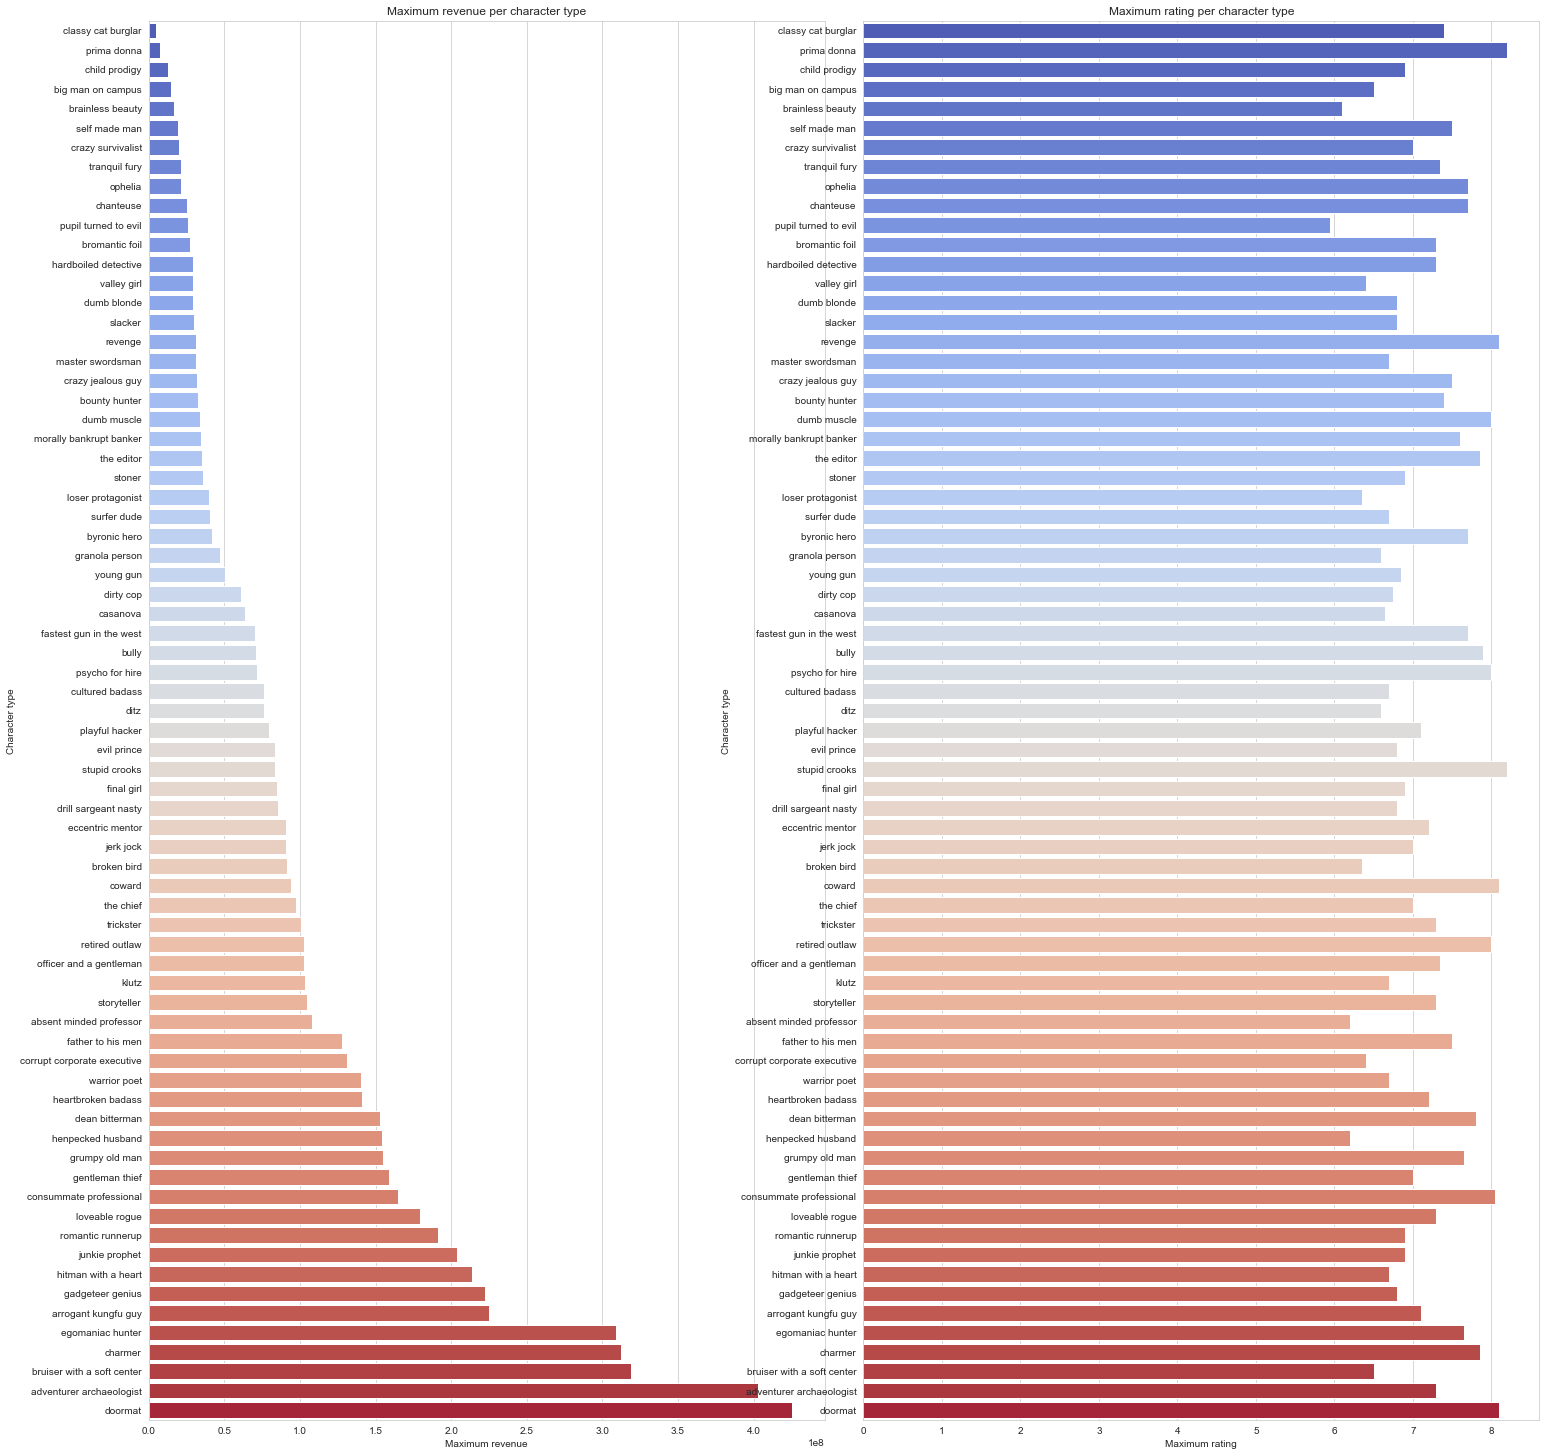

<Figure size 1440x1440 with 0 Axes>

In [151]:
# Here we plot the best revenue and its rating
revenue_rating_sentiment_per_type = revenue_rating_sentiment_per_type.sort_values('median_revenue')
fig, ax = plt.subplots(1,2, figsize=(20, 20))
palette = sns.color_palette("coolwarm", n_colors = len(revenue_rating_sentiment_per_type))
plt.tight_layout(h_pad=2)
plt.figure(figsize=(20,20))
sns.barplot(data=revenue_rating_sentiment_per_type, x="median_revenue", y="type",ax = ax[0],  palette = palette).set(title='Maximum revenue per character type',xlabel='Maximum revenue', ylabel='Character type')
sns.barplot(data=revenue_rating_sentiment_per_type, x="median_rating", y="type",ax = ax[1],  palette = palette).set(title='Maximum rating per character type',xlabel='Maximum rating', ylabel='Character type')

### 6) Plot analysis

Here we do some processing on the plot summaries for further use in Milestone 3.

In [ ]:
# Load the plot summaries
plots_df = pd.read_csv('data/plot_summaries.txt', sep='	')
plots_df = plots_df[plots_df["wikipedia_id"].isin(metadata_df["Wikipedia movie ID"])]

In [ ]:
plots_df.head()

In [ ]:
len(plots_df)

In [ ]:
subpath = "data/corenlp_plot_summaries/"
starting_positions = {"VB", "NN", "NP", "PP", "RB"}
import os

def get_important_lemmas(wiki_id: int) -> list[str]:
    """
    Retrieve important lemmas from
    :param wiki_id: wikipedia movie id
    :return: list of lemmas of important words
    """

    def is_important(token):
        tok = token.find("POS").text
        for pos in starting_positions:
            if tok.startswith(pos):
                return True
        return False

    def to_lemma(token):
        return token.find("lemma").text

    zip_name = str(wiki_id) + ".xml.gz"

    if not os.path.isfile(subpath + zip_name):
        print(f"Missing file with id {wiki_id}")
        return []

    with gzip.open(subpath + zip_name, 'r') as file:
        xmltree = ET.ElementTree(ET.fromstring(file.read())).getroot()

    return list(map(to_lemma, filter(is_important, xmltree.iter("token"))))

In [ ]:
%%time
pickle_path = "data/pickled_data/plots_pickle.pkl"
if os.path.isfile(pickle_path):
    plots_df = pd.read_pickle(pickle_path)
else:
    plots_df['important_lemmas'] = plots_df['wikipedia_id'].apply(get_important_lemmas)
    plots_df.to_pickle(pickle_path)
plots_df.head()

In [ ]:
len(plots_df)

In [ ]:
lengths = plots_df["important_lemmas"].apply(len)
print(f"{len(plots_df[lengths == 0])} movie(s) has/have no core nlp plot summary.")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x)